In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from functools import lru_cache
from numpy.linalg import inv
from IPython.display import display, Math
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
import time
import os
from scipy.stats import gamma
from scipy.special import erf, gammaincinv

In [3]:
start_time = time.time()

# Load Pantheon+ light curve data
pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')

# Load and reshape the covariance matrix
with open("sys_full_long-pp.txt", "r") as f:
    lines = f.readlines()

N = int(lines[0].strip())  # Size of the matrix
flat_data = np.array([float(x.strip()) for x in lines[1:]])
C_full = flat_data.reshape((N, N))
C_inv = np.linalg.inv(C_full)  # Invert the full covariance matrix


end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

/var/tmp/stamou/ipykernel_1771605/3854114429.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')


⏱️ Execution time: 1.17 seconds


In [4]:
# Load Hubble Diagram Redshift from PANTHEON
z = pantheon_data['zHD'].values
# Define SNe with Cepheid host
is_calibrator = pantheon_data['IS_CALIBRATOR'].values.astype(int)
# Load the corrected apparent magnitudes and distance moduli from Cepheid hosts
mB = pantheon_data['m_b_corr'].values
mu_Ceph = pantheon_data['CEPH_DIST'].values
# Speed of light in km/s
c_km_s = 299792.458 

In [5]:
# --- No-transition Hubble parameter for flat w0CDM ---
def E_w0CDM(z, Omega_m, w0):
    term1 = Omega_m * (1 + z)**3
    term2 = (1 - Omega_m) * (1 + z)**(3 * (1 + w0))
    return np.sqrt(term1 + term2)

# --- No-transition integral for luminosity distance (w0CDM) ---
def integral_dL_w0CDM(z, H0, Omega_m, w0):
    integrand = lambda zp: 1 / E_w0CDM(zp, Omega_m, w0)
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

# --- No-transition theoretical distance modulus (w0CDM) ---
def mu_theory_w0CDM(z_array, H0, Omega_m, w0):
    return np.array([
        5 * np.log10(integral_dL_w0CDM(float(z), H0, Omega_m, w0)) + 25
        for z in z_array
    ])

# --- No-transition chi-square function for w0CDM ---
def chi2_w0CDM(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, Omega_m, w0 = params
    mu_model = mu_theory_w0CDM(z, H0, Omega_m, w0)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z >= 0.0, mB - M - mu_model, 0.0)
    )
    return Q.T @ C_inv @ Q

# --- Initial guess for parameters: M, H0, Omega_m, w0 ---
initial_guess = [-19.25, 72.0, 0.3, -1.0]

# --- Parameter bounds: (M, H0, Omega_m, w0) ---
bounds = [(-20, -19.0), (68, 78), (0.1, 0.5), (-1.5, -0.3)]

# --- Minimization ---
result = minimize(
    chi2_w0CDM,
    initial_guess,
    bounds=bounds,
    args=(z, mB, mu_Ceph, is_calibrator, C_inv),
    method='L-BFGS-B',
    options={'maxiter': 10000, 'disp': True, 'ftol': 1e-9,'gtol': 1e-6 }
)

# --- Extract best-fit parameters ---
M_best, H0_best, Omega_m_best, w0_best = result.x

# --- Chi-square at minimum ---
chi2_min = result.fun

# --- Step 1: Define grid around best-fit values ---
h_best = H0_best / 100.0
delta_M, delta_Om, delta_h, delta_w0 = 0.02, 0.02, 0.002, 0.02

M_vals = np.array([M_best - delta_M, M_best, M_best + delta_M])
Om_vals = np.array([Omega_m_best - delta_Om, Omega_m_best, Omega_m_best + delta_Om])
h_vals = np.array([h_best - delta_h, h_best, h_best + delta_h])
w0_vals = np.array([w0_best - delta_w0, w0_best, w0_best + delta_w0])

# --- Step 2: Evaluate chi-square on 4D grid ---
chi2_cube = []
grid_points = []

for M in M_vals:
    for Om in Om_vals:
        for h in h_vals:
            H0 = h * 100.0
            for w0 in w0_vals:
                chi2_val = chi2_w0CDM([M, H0, Om, w0], z, mB, mu_Ceph, is_calibrator, C_inv)
                chi2_cube.append(chi2_val)
                grid_points.append([M, Om, h, w0])

chi2_cube = np.array(chi2_cube)
grid_points = np.array(grid_points)

# --- Step 3: Build design matrix for 4D quadratic form ---
def build_quadratic_features_4D(X):
    M, Om, h, w0 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    Φ = np.column_stack([
        M, Om, h, w0,
        M**2, Om**2, h**2, w0**2,
        M*Om, M*h, M*w0,
        Om*h, Om*w0,
        h*w0,
        np.ones_like(M)
    ])
    return Φ

Φ = build_quadratic_features_4D(grid_points)

# --- Step 4: Fit quadratic model and extract Fisher matrix ---
model = LinearRegression(fit_intercept=False)
model.fit(Φ, chi2_cube)
coeffs = model.coef_

# --- Fisher matrix (4x4) ---
Fisher = np.zeros((4, 4))
Fisher[0, 0] = coeffs[4]  # M^2
Fisher[1, 1] = coeffs[5]  # Om^2
Fisher[2, 2] = coeffs[6]  # h^2
Fisher[3, 3] = coeffs[7]  # w0^2

cross_indices = {
    (0, 1): 8, (0, 2): 9, (0, 3): 10,
    (1, 2): 11, (1, 3): 12,
    (2, 3): 13
}
for (i, j), idx in cross_indices.items():
    Fisher[i, j] = Fisher[j, i] = 0.5 * coeffs[idx]

# --- Covariance matrix and 1-sigma errors ---
cov_matrix = np.linalg.inv(Fisher)
errors = np.sqrt(np.diag(cov_matrix))

from IPython.display import Markdown, display

# --- Step 6: LaTeX output for w0CDM ---
latex_output = fr'''
<div align="center">$\Large\bf{{Fisher\ Matrix}}$</div>

\begin{{bmatrix}}
{Fisher[0,0]:.2f} & {Fisher[0,1]:.2f} & {Fisher[0,2]:.2f} & {Fisher[0,3]:.2f} \\
{Fisher[1,0]:.2f} & {Fisher[1,1]:.2f} & {Fisher[1,2]:.2f} & {Fisher[1,3]:.2f} \\
{Fisher[2,0]:.2f} & {Fisher[2,1]:.2f} & {Fisher[2,2]:.2f} & {Fisher[2,3]:.2f} \\
{Fisher[3,0]:.2f} & {Fisher[3,1]:.2f} & {Fisher[3,2]:.2f} & {Fisher[3,3]:.2f}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Covariance\ Matrix}}$</div>

\begin{{bmatrix}}
{cov_matrix[0,0]:.2e} & {cov_matrix[0,1]:.2e} & {cov_matrix[0,2]:.2e} & {cov_matrix[0,3]:.2e} \\
{cov_matrix[1,0]:.2e} & {cov_matrix[1,1]:.2e} & {cov_matrix[1,2]:.2e} & {cov_matrix[1,3]:.2e} \\
{cov_matrix[2,0]:.2e} & {cov_matrix[2,1]:.2e} & {cov_matrix[2,2]:.2e} & {cov_matrix[2,3]:.2e} \\
{cov_matrix[3,0]:.2e} & {cov_matrix[3,1]:.2e} & {cov_matrix[3,2]:.2e} & {cov_matrix[3,3]:.2e}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Best-fit\ Parameters}}$</div>

\begin{{aligned}}
M &= {M_best:.5f} \pm {errors[0]:.5f} \\
\Omega_m &= {Omega_m_best:.5f} \pm {errors[1]:.5f} \\
h &= {h_best:.5f} \pm {errors[2]:.5f} \\
w_0 &= {w0_best:.5f} \pm {errors[3]:.5f} \\
\chi^2_\text{{min}} &= {chi2_min:.2f}
\end{{aligned}}
'''

display(Markdown(latex_output))



<div align="center">$\Large\bf{Fisher\ Matrix}$</div>

\begin{bmatrix}
75296.15 & -22036.99 & -219651.92 & -12990.70 \\
-22036.99 & 9273.43 & 64982.30 & 5106.75 \\
-219651.92 & 64982.30 & 650783.15 & 38322.17 \\
-12990.70 & 5106.75 & 38322.17 & 2892.94
\end{bmatrix}

<div align="center">$\Large\bf{Covariance\ Matrix}$</div>

\begin{bmatrix}
8.67e-04 & -3.69e-05 & 2.87e-04 & 1.51e-04 \\
-3.69e-05 & 4.78e-03 & 7.68e-05 & -9.63e-03 \\
2.87e-04 & 7.68e-05 & 1.04e-04 & -2.22e-04 \\
1.51e-04 & -9.63e-03 & -2.22e-04 & 2.10e-02
\end{bmatrix}

<div align="center">$\Large\bf{Best-fit\ Parameters}$</div>

\begin{aligned}
M &= -19.24758 \pm 0.02944 \\
\Omega_m &= 0.28782 \pm 0.06916 \\
h &= 0.73305 \pm 0.01019 \\
w_0 &= -0.89076 \pm 0.14476 \\
\chi^2_\text{min} &= 1522.48
\end{aligned}


In [6]:
def chi2_transition_w0CDM(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M_low, M_high, H0, Omega_m, w0, d_crit = params

    # Theoretical distance modulus from w0CDM
    mu_model = mu_theory_w0CDM(z, H0, Omega_m, w0)

    # Use apparent magnitude to calculate SH0ES-based distance modulus
    mu_SH0ES = mB + 19.253  # SH0ES fixed M = -19.253
    mu_crit = 5 * np.log10(d_crit) + 25

    # Assign M_low or M_high depending on location relative to d_crit
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)

    # Construct Q vector
    Q = np.where(
        is_calibrator == 1,
        mB - M_used - mu_Ceph,
        np.where(z >= 0.0, mB - M_used - mu_model, 0.0)
    )

    return Q.T @ C_inv @ Q

from scipy.optimize import minimize

# --- Initial guess for parameters: M_low, M_high, H0, Omega_m, w0, d_crit ---
initial_guess_transition = [-19.4, -19.28, 72.0, 0.3, -1.0, 19.9]

# --- Parameter bounds ---
# (M_low, M_high, H0, Omega_m, w0, d_crit)
bounds_transition = [
    (-19.8, -19.15),  # M_low
    (-19.8, -19.15),  # M_high
    (70, 78),       # H0
    (0.1, 0.5),     # Omega_m
    (-1.5, -0.3),   # w0
    (19.5,20.5)     # d_crit in Mpc
]

# --- Run minimization ---
result_transition = minimize(
    chi2_transition_w0CDM,
    initial_guess_transition,
    bounds=bounds_transition,
    args=(z, mB, mu_Ceph, is_calibrator, C_inv),
    method='L-BFGS-B',
    options={
        'maxiter': 10000,
        'disp': True,
        'ftol': 1e-9,
        'gtol': 1e-6
    }
)

# --- Extract best-fit parameters ---
M_low_best, M_high_best, H0_best_tr, Omega_m_best_tr, w0_best_tr, d_crit_best = result_transition.x

# --- Chi-square at minimum ---
chi2_min_transition = result_transition.fun

from sklearn.linear_model import LinearRegression
import numpy as np

# --- Step 1: Define grid around best-fit values ---
h_best_tr = H0_best_tr / 100.0
delta = {
    "M_low": 0.02,
    "M_high": 0.02,
    "Omega_m": 0.02,
    "h": 0.002,
    "w0": 0.02,
    "d_crit": 1.0
}

Mlow_vals = np.array([M_low_best - delta["M_low"], M_low_best, M_low_best + delta["M_low"]])
Mhigh_vals = np.array([M_high_best - delta["M_high"], M_high_best, M_high_best + delta["M_high"]])
Om_vals = np.array([Omega_m_best_tr - delta["Omega_m"], Omega_m_best_tr, Omega_m_best_tr + delta["Omega_m"]])
h_vals = np.array([h_best_tr - delta["h"], h_best_tr, h_best_tr + delta["h"]])
w0_vals = np.array([w0_best_tr - delta["w0"], w0_best_tr, w0_best_tr + delta["w0"]])
dcrit_vals = np.array([d_crit_best - delta["d_crit"], d_crit_best, d_crit_best + delta["d_crit"]])

# --- Step 2: Evaluate chi-square on 6D grid ---
chi2_cube = []
grid_points = []

for Mlow in Mlow_vals:
    for Mhigh in Mhigh_vals:
        for Om in Om_vals:
            for h in h_vals:
                H0 = h * 100.0
                for w0 in w0_vals:
                    for dcrit in dcrit_vals:
                        chi2_val = chi2_transition_w0CDM(
                            [Mlow, Mhigh, H0, Om, w0, dcrit],
                            z, mB, mu_Ceph, is_calibrator, C_inv
                        )
                        chi2_cube.append(chi2_val)
                        grid_points.append([Mlow, Mhigh, Om, h, w0, dcrit])

chi2_cube = np.array(chi2_cube)
grid_points = np.array(grid_points)

def build_quadratic_features_6D(X):
    Mlow, Mhigh, Om, h, w0, dcrit = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5]
    Φ = np.column_stack([
        Mlow, Mhigh, Om, h, w0, dcrit,
        Mlow**2, Mhigh**2, Om**2, h**2, w0**2, dcrit**2,
        Mlow*Mhigh, Mlow*Om, Mlow*h, Mlow*w0, Mlow*dcrit,
        Mhigh*Om, Mhigh*h, Mhigh*w0, Mhigh*dcrit,
        Om*h, Om*w0, Om*dcrit,
        h*w0, h*dcrit, w0*dcrit,
        np.ones_like(Mlow)
    ])
    return Φ

Φ = build_quadratic_features_6D(grid_points)
model = LinearRegression(fit_intercept=False)
model.fit(Φ, chi2_cube)
coeffs = model.coef_

# --- Initialize Fisher matrix ---
Fisher = np.zeros((6, 6))

# Diagonal terms
Fisher[0, 0] = coeffs[6]   # Mlow^2
Fisher[1, 1] = coeffs[7]   # Mhigh^2
Fisher[2, 2] = coeffs[8]   # Om^2
Fisher[3, 3] = coeffs[9]   # h^2
Fisher[4, 4] = coeffs[10]  # w0^2
Fisher[5, 5] = coeffs[11]  # dcrit^2

# Off-diagonal terms (symmetric)
cross_indices = {
    (0, 1): 12, (0, 2): 13, (0, 3): 14, (0, 4): 15, (0, 5): 16,
    (1, 2): 17, (1, 3): 18, (1, 4): 19, (1, 5): 20,
    (2, 3): 21, (2, 4): 22, (2, 5): 23,
    (3, 4): 24, (3, 5): 25,
    (4, 5): 26
}
for (i, j), idx in cross_indices.items():
    Fisher[i, j] = Fisher[j, i] = 0.5 * coeffs[idx]

# --- Covariance matrix and 1-sigma errors ---
cov_matrix = np.linalg.inv(Fisher)
errors = np.sqrt(np.diag(cov_matrix))

from IPython.display import Markdown, display

latex_output_transition = fr'''
<div align="center">$\Large\bf{{Fisher\ Matrix}}$</div>

\begin{{bmatrix}}
{Fisher[0,0]:.2f} & {Fisher[0,1]:.2f} & {Fisher[0,2]:.2f} & {Fisher[0,3]:.2f} & {Fisher[0,4]:.2f} & {Fisher[0,5]:.2f} \\
{Fisher[1,0]:.2f} & {Fisher[1,1]:.2f} & {Fisher[1,2]:.2f} & {Fisher[1,3]:.2f} & {Fisher[1,4]:.2f} & {Fisher[1,5]:.2f} \\
{Fisher[2,0]:.2f} & {Fisher[2,1]:.2f} & {Fisher[2,2]:.2f} & {Fisher[2,3]:.2f} & {Fisher[2,4]:.2f} & {Fisher[2,5]:.2f} \\
{Fisher[3,0]:.2f} & {Fisher[3,1]:.2f} & {Fisher[3,2]:.2f} & {Fisher[3,3]:.2f} & {Fisher[3,4]:.2f} & {Fisher[3,5]:.2f} \\
{Fisher[4,0]:.2f} & {Fisher[4,1]:.2f} & {Fisher[4,2]:.2f} & {Fisher[4,3]:.2f} & {Fisher[4,4]:.2f} & {Fisher[4,5]:.2f} \\
{Fisher[5,0]:.2f} & {Fisher[5,1]:.2f} & {Fisher[5,2]:.2f} & {Fisher[5,3]:.2f} & {Fisher[5,4]:.2f} & {Fisher[5,5]:.2f}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Covariance\ Matrix}}$</div>

\begin{{bmatrix}}
{cov_matrix[0,0]:.2e} & {cov_matrix[0,1]:.2e} & {cov_matrix[0,2]:.2e} & {cov_matrix[0,3]:.2e} & {cov_matrix[0,4]:.2e} & {cov_matrix[0,5]:.2e} \\
{cov_matrix[1,0]:.2e} & {cov_matrix[1,1]:.2e} & {cov_matrix[1,2]:.2e} & {cov_matrix[1,3]:.2e} & {cov_matrix[1,4]:.2e} & {cov_matrix[1,5]:.2e} \\
{cov_matrix[2,0]:.2e} & {cov_matrix[2,1]:.2e} & {cov_matrix[2,2]:.2e} & {cov_matrix[2,3]:.2e} & {cov_matrix[2,4]:.2e} & {cov_matrix[2,5]:.2e} \\
{cov_matrix[3,0]:.2e} & {cov_matrix[3,1]:.2e} & {cov_matrix[3,2]:.2e} & {cov_matrix[3,3]:.2e} & {cov_matrix[3,4]:.2e} & {cov_matrix[3,5]:.2e} \\
{cov_matrix[4,0]:.2e} & {cov_matrix[4,1]:.2e} & {cov_matrix[4,2]:.2e} & {cov_matrix[4,3]:.2e} & {cov_matrix[4,4]:.2e} & {cov_matrix[4,5]:.2e} \\
{cov_matrix[5,0]:.2e} & {cov_matrix[5,1]:.2e} & {cov_matrix[5,2]:.2e} & {cov_matrix[5,3]:.2e} & {cov_matrix[5,4]:.2e} & {cov_matrix[5,5]:.2e}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Best-fit\ Parameters}}$</div>

\begin{{aligned}}
M_\text{{low}} &= {M_low_best:.5f} \pm {errors[0]:.5f} \\
M_\text{{high}} &= {M_high_best:.5f} \pm {errors[1]:.5f} \\
\Omega_m &= {Omega_m_best_tr:.5f} \pm {errors[2]:.5f} \\
h &= {h_best_tr:.5f} \pm {errors[3]:.5f} \\
w_0 &= {w0_best_tr:.5f} \pm {errors[4]:.5f} \\
d_{{\text{{crit}}}}~[\text{{Mpc}}] &= {d_crit_best:.2f} \pm {errors[5]:.2f} \\
\chi^2_\text{{min}} &= {chi2_min_transition:.2f}
\end{{aligned}}
'''

display(Markdown(latex_output_transition))



<div align="center">$\Large\bf{Fisher\ Matrix}$</div>

\begin{bmatrix}
520.19 & -100.38 & -94.46 & -559.92 & -54.82 & -0.31 \\
-100.38 & 74976.71 & -22101.49 & -215753.93 & -12815.01 & -12.99 \\
-94.46 & -22101.49 & 9392.94 & 64456.48 & 5084.95 & 4.39 \\
-559.92 & -215753.93 & 64456.48 & 631154.66 & 37388.95 & 2.24 \\
-54.82 & -12815.01 & 5084.95 & 37388.95 & 2836.01 & 2.21 \\
-0.31 & -12.99 & 4.39 & 2.24 & 2.21 & 3.54
\end{bmatrix}

<div align="center">$\Large\bf{Covariance\ Matrix}$</div>

\begin{bmatrix}
2.24e-03 & 5.59e-04 & -7.11e-05 & 1.86e-04 & 2.47e-04 & 2.06e-03 \\
5.59e-04 & 9.87e-04 & -2.27e-05 & 3.34e-04 & 1.08e-04 & 3.42e-03 \\
-7.11e-05 & -2.27e-05 & 4.40e-03 & 7.46e-05 & -8.97e-03 & 1.18e-05 \\
1.86e-04 & 3.34e-04 & 7.46e-05 & 1.22e-04 & -2.27e-04 & 1.21e-03 \\
2.47e-04 & 1.08e-04 & -8.97e-03 & -2.27e-04 & 1.99e-02 & -7.51e-04 \\
2.06e-03 & 3.42e-03 & 1.18e-05 & 1.21e-03 & -7.51e-04 & 2.95e-01
\end{bmatrix}

<div align="center">$\Large\bf{Best-fit\ Parameters}$</div>

\begin{aligned}
M_\text{low} &= -19.40451 \pm 0.04737 \\
M_\text{high} &= -19.21420 \pm 0.03141 \\
\Omega_m &= 0.29136 \pm 0.06633 \\
h &= 0.74436 \pm 0.01103 \\
w_0 &= -0.89903 \pm 0.14117 \\
d_{\text{crit}}~[\text{Mpc}] &= 19.90 \pm 0.54 \\
\chi^2_\text{min} &= 1507.30
\end{aligned}


In [7]:
# --- AIC computation function ---
def compute_aic(chi2_min, num_params):
    """
    Compute the Akaike Information Criterion.
    AIC = chi2_min + 2 * k
    """
    return chi2_min + 2 * num_params

# --- Define model details ---
chi2_no_transition = chi2_min        # from w0CDM no-transition
chi2_transition = chi2_min_transition  # from w0CDM with M-transition

k_no_transition = 4   # M, H0, Omega_m, w0
k_transition = 6      # M_low, M_high, H0, Omega_m, w0, d_crit

# --- Compute AIC values ---
aic_no_transition = compute_aic(chi2_no_transition, k_no_transition)
aic_transition = compute_aic(chi2_transition, k_transition)
delta_aic = aic_transition - aic_no_transition

# --- Display AIC results ---
latex_output = fr"""
\begin{{aligned}}
\text{{AIC (No-Transition)}} &= {aic_no_transition:.2f} \\
\text{{AIC (Transition Model)}} &= {aic_transition:.2f} \\
\Delta \mathrm{{AIC}} &= {delta_aic:.2f}
\end{{aligned}}
"""

display(Markdown(latex_output))

# --- Interpretation ---
if delta_aic > 10:
    interpretation = "Strong preference for the No-Transition model."
elif delta_aic > 5:
    interpretation = "Moderate preference for the No-Transition model."
elif delta_aic > 2:
    interpretation = "Weak preference for the No-Transition model."
elif delta_aic > -2:
    interpretation = "Models are indistinguishable."
elif delta_aic > -5:
    interpretation = "Weak preference for the Transition model."
elif delta_aic > -10:
    interpretation = "Moderate preference for the Transition model."
else:
    interpretation = "Strong preference for the Transition model."

display(Markdown(f"**Interpretation**: {interpretation}"))


\begin{aligned}
\text{AIC (No-Transition)} &= 1530.48 \\
\text{AIC (Transition Model)} &= 1519.30 \\
\Delta \mathrm{AIC} &= -11.18
\end{aligned}


**Interpretation**: Strong preference for the Transition model.

In [8]:
# --- BIC computation function ---
def compute_bic(chi2_min, num_params, num_data_points):
    """
    Compute the Bayesian Information Criterion.
    BIC = chi2_min + k * ln(n)
    """
    return chi2_min + num_params * np.log(num_data_points)

# --- Define number of data points ---
n_data_points = len(mB)  # or len(mu_data), assuming both are same length

# --- Compute BIC values ---
bic_no_transition = compute_bic(chi2_no_transition, k_no_transition, n_data_points)
bic_transition = compute_bic(chi2_transition, k_transition, n_data_points)
delta_bic = bic_transition - bic_no_transition

# --- Display BIC results ---
latex_output_bic = fr"""
\begin{{aligned}}
\text{{BIC (No-Transition)}} &= {bic_no_transition:.2f} \\
\text{{BIC (Transition Model)}} &= {bic_transition:.2f} \\
\Delta \mathrm{{BIC}} &= {delta_bic:.2f}
\end{{aligned}}
"""

display(Markdown(latex_output_bic))

# --- Interpretation ---
if delta_bic > 10:
    interpretation_bic = "Strong preference for the No-Transition model."
elif delta_bic > 6:
    interpretation_bic = "Moderate preference for the No-Transition model."
elif delta_bic > 2:
    interpretation_bic = "Weak preference for the No-Transition model."
elif delta_bic > -2:
    interpretation_bic = "Models are indistinguishable."
elif delta_bic > -6:
    interpretation_bic = "Weak preference for the Transition model."
elif delta_bic > -10:
    interpretation_bic = "Moderate preference for the Transition model."
else:
    interpretation_bic = "Strong preference for the Transition model."

display(Markdown(f"**BIC Interpretation**: {interpretation_bic}"))



\begin{aligned}
\text{BIC (No-Transition)} &= 1552.24 \\
\text{BIC (Transition Model)} &= 1551.93 \\
\Delta \mathrm{BIC} &= -0.30
\end{aligned}


**BIC Interpretation**: Models are indistinguishable.

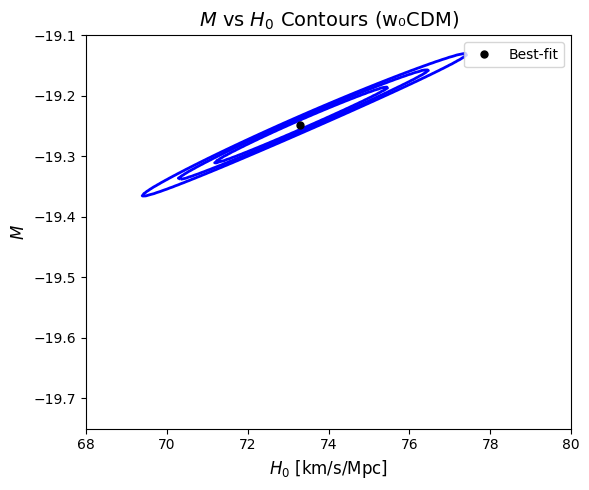

⏱️ Execution time: 175.78 seconds


In [7]:
start_time = time.time()

# --- Cached luminosity distance integrator for w0CDM ---
@lru_cache(maxsize=None)
def integral_dL_w0CDM_cached(z, H0, Omega_m, w0):
    integrand = lambda zp: 1 / np.sqrt(Omega_m * (1 + zp)**3 + (1 - Omega_m) * (1 + zp)**(3 * (1 + w0)))
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

# --- Distance modulus from w0CDM using cached integrator ---
def mu_theory_w0CDM(z_array, H0, Omega_m, w0):
    return np.array([
        5 * np.log10(integral_dL_w0CDM_cached(float(z), float(H0), float(Omega_m), float(w0))) + 25
        for z in z_array
    ])

# --- Chi2 function for w0CDM ---
def chi2_w0CDM(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, Omega_m, w0 = params
    mu_model = mu_theory_w0CDM(z, H0, Omega_m, w0)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        mB - M - mu_model
    )
    return Q.T @ C_inv @ Q

# --- Delta chi² levels (dof = 2 for 2D contours) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 4) for n in [1, 2, 3]]

# --- Grid setup for M vs H0 ---
M_range = np.linspace(-19.75, -19.10,180)
H0_range = np.linspace(68, 80, 180)

# --- Best-fit values (replace these with actual results from your minimizer) ---
# These should be defined earlier in your notebook
M_best = M_best
H0_best = H0_best
Omega_m_best = Omega_m_best
w0_best = w0_best

# --- Grid evaluation for chi2(M, H0) ---
chi2_grid = np.array([
    [chi2_w0CDM([M, H0, Omega_m_best, w0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
     for H0 in H0_range]
    for M in M_range
])

# --- Save grid data ---
np.savez("contour_data/contour_data_M_H0_w0CDM.npz",
         M=M_range, H0=H0_range, chi2=chi2_grid,
         M_best=M_best, H0_best=H0_best)

# --- Δχ² and plot ---
chi2_min = chi2_w0CDM([M_best, H0_best, Omega_m_best, w0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2= chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(H0_range, M_range, dchi2, levels=levels, colors='blue', linewidths=2)
plt.plot(H0_best, M_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.title(r"$M$ vs $H_0$ Contours (w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("M_vs_H0_w0CDM.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

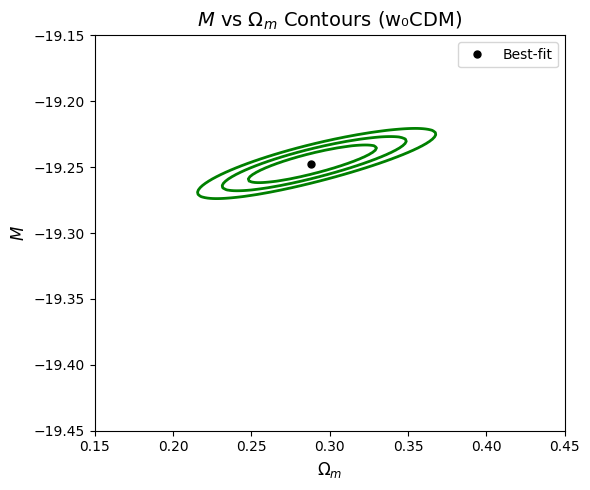

⏱️ Execution time: 208.41 seconds


In [10]:
start_time=time.time()

# --- Grid setup for M vs Omega_m ---
M_range = np.linspace(-19.45, -19.15, 180)
Om_range = np.linspace(0.15, 0.45, 180)

# --- Best-fit values (from minimization) ---
M_best = M_best
H0_best = H0_best
Omega_m_best = Omega_m_best
w0_best = w0_best

# --- Evaluate chi2(M, Omega_m), keeping H0 and w0 fixed ---
chi2_grid = np.array([
    [chi2_w0CDM([M, H0_best, Om, w0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
     for Om in Om_range]
    for M in M_range
])

# --- Save data ---
np.savez("contour_data/contour_data_M_Om_w0CDM.npz",
         M=M_range, Om=Om_range, chi2=chi2_grid,
         M_best=M_best, Om_best=Omega_m_best)

# --- Compute Δχ² and plot ---
chi2_min = chi2_w0CDM([M_best, H0_best, Omega_m_best, w0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(Om_range, M_range, dchi2, levels=levels, colors='green', linewidths=2)
plt.plot(Omega_m_best, M_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.title(r"$M$ vs $\Omega_m$ Contours (w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("M_vs_Omega_w0CDM.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

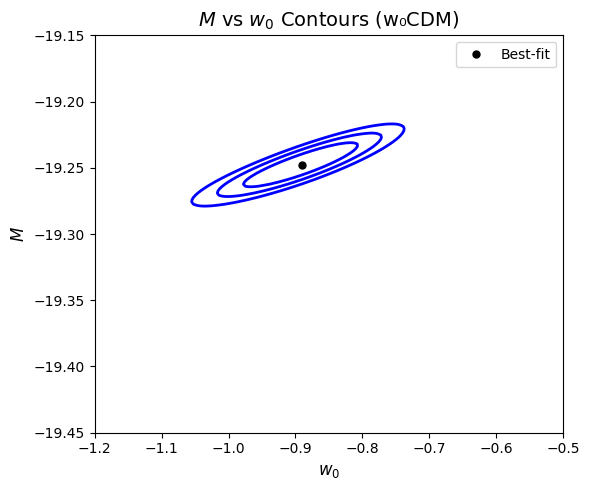

⏱️ Execution time: 179.51 seconds


In [9]:
start_time = time.time()

# --- Grid setup for M vs w0 ---
M_range = np.linspace(-19.45, -19.15, 180)
w0_range = np.linspace(-1.2, -0.5, 180)

# --- Best-fit values (from minimization) ---
M_best = M_best
H0_best = H0_best
Omega_m_best = Omega_m_best
w0_best = w0_best

# --- Evaluate chi2(M, w0), keeping H0 and Omega_m fixed ---
chi2_grid = np.array([
    [chi2_w0CDM([M, H0_best, Omega_m_best, w0], z, mB, mu_Ceph, is_calibrator, C_inv)
     for w0 in w0_range]
    for M in M_range
])

# --- Save data ---
np.savez("contour_data/contour_data_M_w0_w0CDM.npz",
         M=M_range, w0=w0_range, chi2=chi2_grid,
         M_best=M_best, w0_best=w0_best)

# --- Compute Δχ² and plot ---
chi2_min = chi2_w0CDM([M_best, H0_best, Omega_m_best, w0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(w0_range, M_range, dchi2, levels=levels, colors='blue', linewidths=2)
plt.plot(w0_best, M_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$w_0$", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.title(r"$M$ vs $w_0$ Contours (w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("M_vs_w0_w0CDM.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


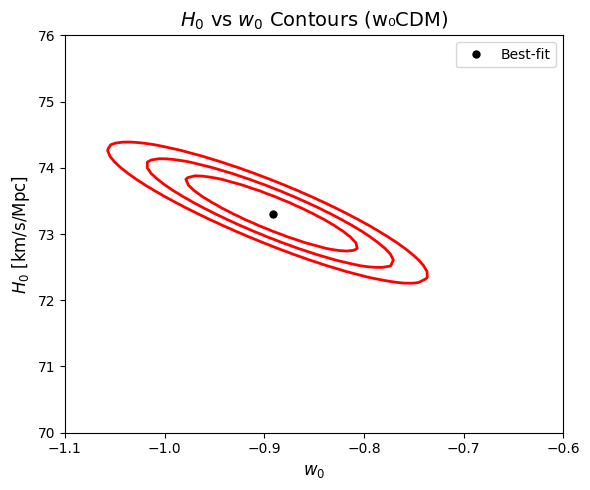

⏱️ Execution time: 360.88 seconds


In [8]:
start_time = time.time()

# --- Grid setup for H0 vs w0 ---
H0_range = np.linspace(70, 76, 70)
w0_range = np.linspace(-1.1, -0.6, 70)

# --- Best-fit values (from minimization) ---
M_best = M_best
H0_best = H0_best
Omega_m_best = Omega_m_best
w0_best = w0_best

# --- Evaluate chi2(H0, w0), keeping M and Omega_m fixed ---
chi2_grid = np.array([
    [chi2_w0CDM([M_best, H0, Omega_m_best, w0], z, mB, mu_Ceph, is_calibrator, C_inv)
     for w0 in w0_range]
    for H0 in H0_range
])

# --- Save data ---
np.savez("contour_data/contour_data_H0_w0_w0CDM.npz",
         H0=H0_range, w0=w0_range, chi2=chi2_grid,
         H0_best=H0_best, w0_best=w0_best)

# --- Compute Δχ² and plot ---
chi2_min = chi2_w0CDM([M_best, H0_best, Omega_m_best, w0_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(w0_range, H0_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(w0_best, H0_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$w_0$", fontsize=12)
plt.ylabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.title(r"$H_0$ vs $w_0$ Contours (w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("H0_vs_w0_w0CDM.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


In [10]:
# --- Δχ² levels for transition model (6 parameters total) ---
# --- Delta chi² levels (dof = 2 for 2D contours) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)
levels = [delta_chi2(n, 4) for n in [1, 2, 3]]
levels_transition = [delta_chi2(n, 6) for n in [1, 2, 3]]

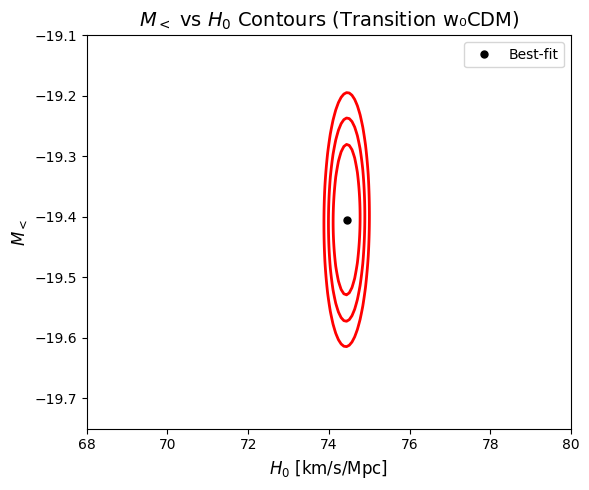

⏱️ Execution time: 169.48 seconds


In [15]:
start_time = time.time()

# --- Grid setup for M_low vs H0 ---
Mlow_range = np.linspace(-19.75, -19.1, 180)
H0_range = np.linspace(68, 80, 180)

# --- Best-fit values for fixed parameters ---
M_low_best = M_low_best
M_high_best = M_high_best
H0_best_tr = H0_best_tr
Omega_m_best_tr = Omega_m_best_tr
w0_best_tr = w0_best_tr
d_crit_best = d_crit_best

# --- Evaluate chi²(M_low, H0), fixing M_high, Omega_m, w0, d_crit ---
chi2_grid = np.array([
    [chi2_transition_w0CDM([M_low, M_high_best, H0, Omega_m_best_tr, w0_best_tr, d_crit_best],
                           z, mB, mu_Ceph, is_calibrator, C_inv)
     for H0 in H0_range]
    for M_low in Mlow_range
])

# --- Save data ---
np.savez("contour_data/contour_data_Mlow_H0_w0CDM_transition.npz",
         Mlow=Mlow_range, H0=H0_range, chi2=chi2_grid,
         Mlow_best=M_low_best, H0_best=H0_best_tr)

# --- Compute Δχ² and plot --
chi2_min = chi2_transition_w0CDM(
    [M_low_best, M_high_best, H0_best_tr, Omega_m_best_tr, w0_best_tr, d_crit_best],
    z, mB, mu_Ceph, is_calibrator, C_inv
)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(H0_range, Mlow_range, dchi2, levels=levels_transition, colors='red', linewidths=2)
plt.plot(H0_best_tr, M_low_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M_{<}$", fontsize=12)
plt.title(r"$M_{<}$ vs $H_0$ Contours (Transition w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mlow_vs_H0_w0CDM_transition.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

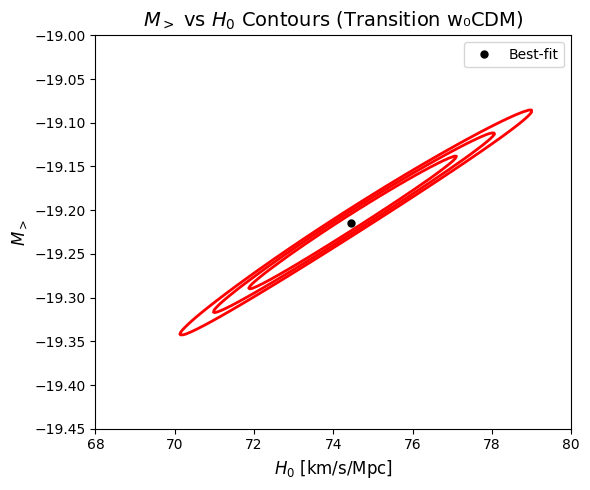

⏱️ Execution time: 168.24 seconds


In [17]:
start_time = time.time()

# --- Grid setup for M_high vs H0 ---
Mhigh_range = np.linspace(-19.45, -19.0, 180)
H0_range = np.linspace(68, 80, 180)

# --- Best-fit values for fixed parameters ---
M_low_best = M_low_best
M_high_best = M_high_best
H0_best_tr = H0_best_tr
Omega_m_best_tr = Omega_m_best_tr
w0_best_tr = w0_best_tr
d_crit_best = d_crit_best

# --- Evaluate chi²(M_high, H0), fixing M_low, Omega_m, w0, d_crit ---
chi2_grid = np.array([
    [chi2_transition_w0CDM([M_low_best, M_high, H0, Omega_m_best_tr, w0_best_tr, d_crit_best],
                           z, mB, mu_Ceph, is_calibrator, C_inv)
     for H0 in H0_range]
    for M_high in Mhigh_range
])

# --- Save data ---
np.savez("contour_data/contour_data_Mhigh_H0_w0CDM_transition.npz",
         Mhigh=Mhigh_range, H0=H0_range, chi2=chi2_grid,
         Mhigh_best=M_high_best, H0_best=H0_best_tr)

# --- Compute Δχ² and plot ---
chi2_min = chi2_transition_w0CDM(
    [M_low_best, M_high_best, H0_best_tr, Omega_m_best_tr, w0_best_tr, d_crit_best],
    z, mB, mu_Ceph, is_calibrator, C_inv
)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(H0_range, Mhigh_range, dchi2, levels=levels_transition, colors='red', linewidths=2)
plt.plot(H0_best_tr, M_high_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M_{>}$", fontsize=12)
plt.title(r"$M_{>}$ vs $H_0$ Contours (Transition w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mhigh_vs_H0_w0CDM_transition.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


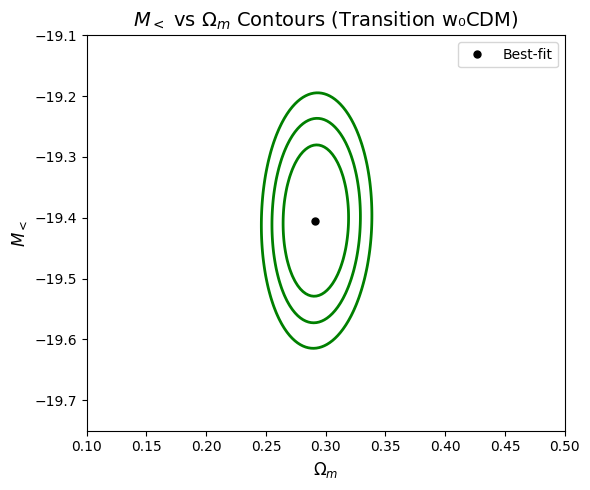

⏱️ Execution time: 190.06 seconds


In [18]:
start_time = time.time()

# --- Grid setup for M_low vs Omega_m ---
Mlow_range = np.linspace(-19.75, -19.1, 180)
Om_range = np.linspace(0.1, 0.5, 180)

# --- Best-fit values for fixed parameters ---
M_low_best = M_low_best
M_high_best = M_high_best
H0_best_tr = H0_best_tr
Omega_m_best_tr = Omega_m_best_tr
w0_best_tr = w0_best_tr
d_crit_best = d_crit_best

# --- Evaluate chi²(M_low, Omega_m), fixing M_high, H0, w0, d_crit ---
chi2_grid = np.array([
    [chi2_transition_w0CDM([M_low, M_high_best, H0_best_tr, Om, w0_best_tr, d_crit_best],
                           z, mB, mu_Ceph, is_calibrator, C_inv)
     for Om in Om_range]
    for M_low in Mlow_range
])

# --- Save data ---
np.savez("contour_data/contour_data_Mlow_Om_w0CDM_transition.npz",
         Mlow=Mlow_range, Om=Om_range, chi2=chi2_grid,
         Mlow_best=M_low_best, Om_best=Omega_m_best_tr)

# --- Compute Δχ² and plot ---
chi2_min = chi2_transition_w0CDM(
    [M_low_best, M_high_best, H0_best_tr, Omega_m_best_tr, w0_best_tr, d_crit_best],
    z, mB, mu_Ceph, is_calibrator, C_inv
)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(Om_range, Mlow_range, dchi2, levels=levels_transition, colors='green', linewidths=2)
plt.plot(Omega_m_best_tr, M_low_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M_{<}$", fontsize=12)
plt.title(r"$M_{<}$ vs $\Omega_m$ Contours (Transition w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mlow_vs_Om_w0CDM_transition.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


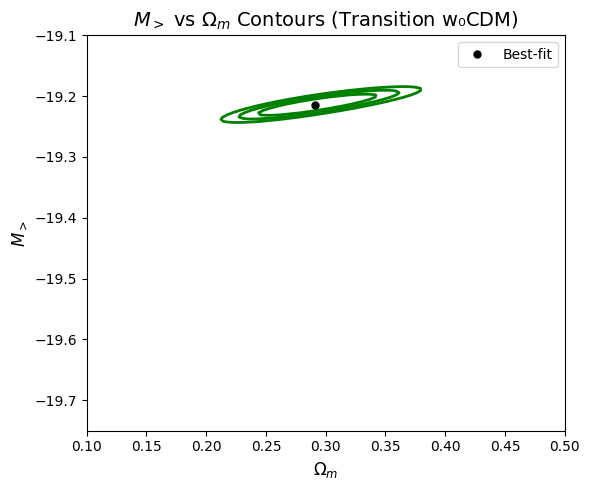

⏱️ Execution time: 176.44 seconds


In [19]:
start_time = time.time()

# --- Grid setup for M_high vs Omega_m ---
Mhigh_range = np.linspace(-19.75, -19.1, 180)
Om_range = np.linspace(0.1, 0.5, 180)

# --- Best-fit values for fixed parameters ---
M_low_best = M_low_best
M_high_best = M_high_best
H0_best_tr = H0_best_tr
Omega_m_best_tr = Omega_m_best_tr
w0_best_tr = w0_best_tr
d_crit_best = d_crit_best

# --- Evaluate chi²(M_high, Omega_m), fixing M_low, H0, w0, d_crit ---
chi2_grid = np.array([
    [chi2_transition_w0CDM([M_low_best, M_high, H0_best_tr, Om, w0_best_tr, d_crit_best],
                           z, mB, mu_Ceph, is_calibrator, C_inv)
     for Om in Om_range]
    for M_high in Mhigh_range
])

# --- Save data ---
np.savez("contour_data/contour_data_Mhigh_Om_w0CDM_transition.npz",
         Mhigh=Mhigh_range, Om=Om_range, chi2=chi2_grid,
         Mhigh_best=M_high_best, Om_best=Omega_m_best_tr)

# --- Compute Δχ² and plot ---
chi2_min = chi2_transition_w0CDM(
    [M_low_best, M_high_best, H0_best_tr, Omega_m_best_tr, w0_best_tr, d_crit_best],
    z, mB, mu_Ceph, is_calibrator, C_inv
)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(Om_range, Mhigh_range, dchi2, levels=levels_transition, colors='green', linewidths=2)
plt.plot(Omega_m_best_tr, M_high_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M_{>}$", fontsize=12)
plt.title(r"$M_{>}$ vs $\Omega_m$ Contours (Transition w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mhigh_vs_Om_w0CDM_transition.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


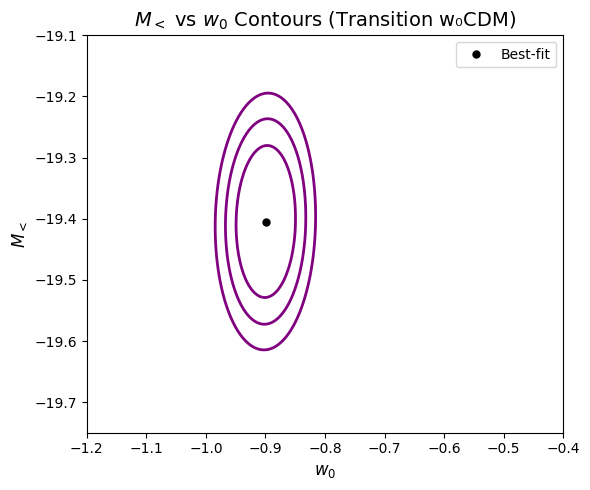

⏱️ Execution time: 187.11 seconds


In [20]:
start_time = time.time()

# --- Grid setup for M_low vs w0 ---
Mlow_range = np.linspace(-19.75, -19.1, 180)
w0_range = np.linspace(-1.2, -0.4, 180)

# --- Best-fit values for fixed parameters ---
M_low_best = M_low_best
M_high_best = M_high_best
H0_best_tr = H0_best_tr
Omega_m_best_tr = Omega_m_best_tr
w0_best_tr = w0_best_tr
d_crit_best = d_crit_best

# --- Evaluate chi²(M_low, w0), fixing M_high, H0, Omega_m, d_crit ---
chi2_grid = np.array([
    [chi2_transition_w0CDM([M_low, M_high_best, H0_best_tr, Omega_m_best_tr, w0, d_crit_best],
                           z, mB, mu_Ceph, is_calibrator, C_inv)
     for w0 in w0_range]
    for M_low in Mlow_range
])

# --- Save data ---
np.savez("contour_data/contour_data_Mlow_w0_w0CDM_transition.npz",
         Mlow=Mlow_range, w0=w0_range, chi2=chi2_grid,
         Mlow_best=M_low_best, w0_best=w0_best_tr)

# --- Compute Δχ² and plot ---
chi2_min = chi2_transition_w0CDM(
    [M_low_best, M_high_best, H0_best_tr, Omega_m_best_tr, w0_best_tr, d_crit_best],
    z, mB, mu_Ceph, is_calibrator, C_inv
)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(w0_range, Mlow_range, dchi2, levels=levels_transition, colors='purple', linewidths=2)
plt.plot(w0_best_tr, M_low_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$w_0$", fontsize=12)
plt.ylabel(r"$M_{<}$", fontsize=12)
plt.title(r"$M_{<}$ vs $w_0$ Contours (Transition w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mlow_vs_w0_w0CDM_transition.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


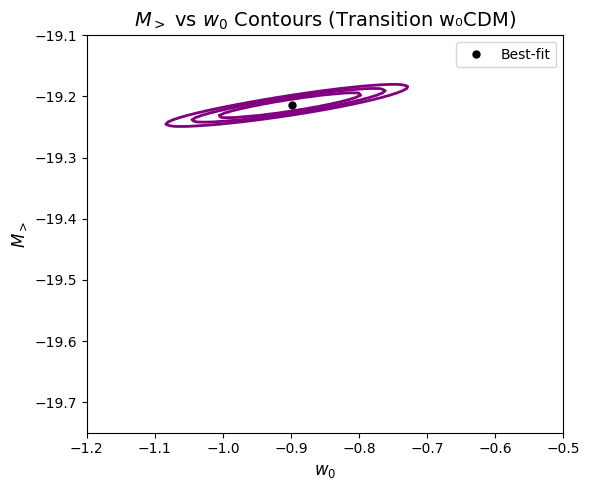

⏱️ Execution time: 185.28 seconds


In [21]:
start_time = time.time()

# --- Grid setup for M_high vs w0 ---
Mhigh_range = np.linspace(-19.75, -19.1, 180)
w0_range = np.linspace(-1.2, -0.5, 180)

# --- Best-fit values for fixed parameters ---
M_low_best = M_low_best
M_high_best = M_high_best
H0_best_tr = H0_best_tr
Omega_m_best_tr = Omega_m_best_tr
w0_best_tr = w0_best_tr
d_crit_best = d_crit_best

# --- Evaluate chi²(M_high, w0), fixing M_low, H0, Omega_m, d_crit ---
chi2_grid = np.array([
    [chi2_transition_w0CDM([M_low_best, M_high, H0_best_tr, Omega_m_best_tr, w0, d_crit_best],
                           z, mB, mu_Ceph, is_calibrator, C_inv)
     for w0 in w0_range]
    for M_high in Mhigh_range
])

# --- Save data ---
np.savez("contour_data/contour_data_Mhigh_w0_w0CDM_transition.npz",
         Mhigh=Mhigh_range, w0=w0_range, chi2=chi2_grid,
         Mhigh_best=M_high_best, w0_best=w0_best_tr)

# --- Compute Δχ² and plot ---
chi2_min = chi2_transition_w0CDM(
    [M_low_best, M_high_best, H0_best_tr, Omega_m_best_tr, w0_best_tr, d_crit_best],
    z, mB, mu_Ceph, is_calibrator, C_inv
)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(w0_range, Mhigh_range, dchi2, levels=levels_transition, colors='purple', linewidths=2)
plt.plot(w0_best_tr, M_high_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$w_0$", fontsize=12)
plt.ylabel(r"$M_{>}$", fontsize=12)
plt.title(r"$M_{>}$ vs $w_0$ Contours (Transition w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mhigh_vs_w0_w0CDM_transition.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


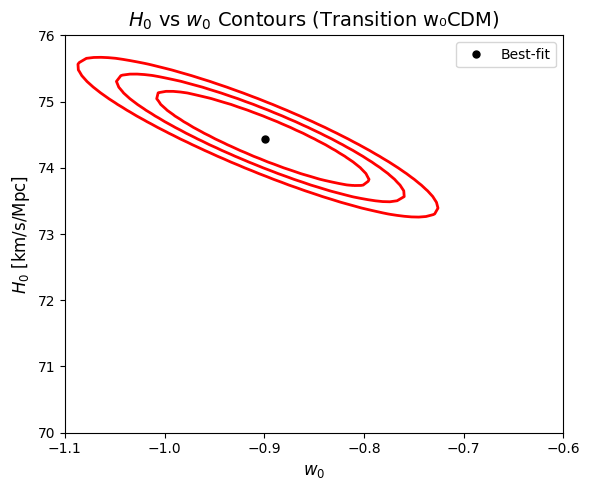

⏱️ Execution time: 361.38 seconds


In [22]:
start_time = time.time()

# --- Grid setup for H0 vs w0 ---
H0_range = np.linspace(70, 76, 70)
w0_range = np.linspace(-1.1, -0.6, 70)

# --- Best-fit values (from transition fit) ---
M_low_best = M_low_best
M_high_best = M_high_best
H0_best_tr = H0_best_tr
Omega_m_best_tr = Omega_m_best_tr
w0_best_tr = w0_best_tr
d_crit_best = d_crit_best

# --- Evaluate chi2(H0, w0), fixing M_low, M_high, Omega_m, d_crit ---
chi2_grid = np.array([
    [chi2_transition_w0CDM([M_low_best, M_high_best, H0, Omega_m_best_tr, w0, d_crit_best],
                           z, mB, mu_Ceph, is_calibrator, C_inv)
     for w0 in w0_range]
    for H0 in H0_range
])

# --- Save data ---
np.savez("contour_data/contour_data_H0_w0_w0CDM_transition.npz",
         H0=H0_range, w0=w0_range, chi2=chi2_grid,
         H0_best=H0_best_tr, w0_best=w0_best_tr)

# --- Compute Δχ² and plot ---
chi2_min = chi2_transition_w0CDM(
    [M_low_best, M_high_best, H0_best_tr, Omega_m_best_tr, w0_best_tr, d_crit_best],
    z, mB, mu_Ceph, is_calibrator, C_inv
)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(w0_range, H0_range, dchi2, levels=levels_transition, colors='red', linewidths=2)
plt.plot(w0_best_tr, H0_best_tr, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$w_0$", fontsize=12)
plt.ylabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.title(r"$H_0$ vs $w_0$ Contours (Transition w₀CDM)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("H0_vs_w0_w0CDM_transition.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


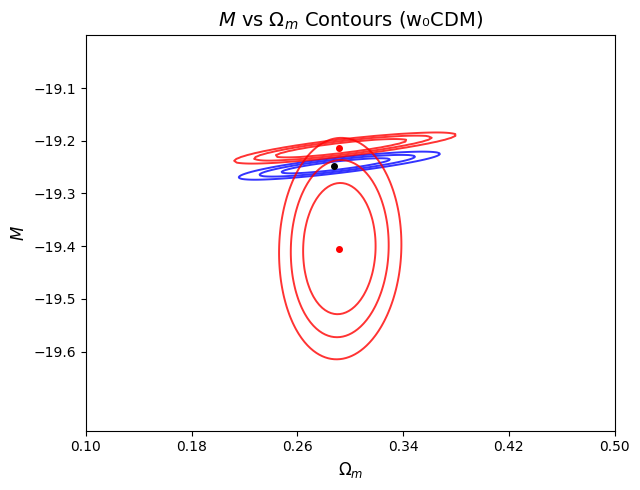

In [16]:
# --- Load raw chi2 data from .npz files ---
data_M_Om = np.load("contour_data/contour_data_M_Om_w0CDM.npz")
data_Mlow_Om = np.load("contour_data/contour_data_Mlow_Om_w0CDM_transition.npz")
data_Mhigh_Om = np.load("contour_data/contour_data_Mhigh_Om_w0CDM_transition.npz")

# --- Grids ---
Om_range = data_M_Om["Om"]
M_range = data_M_Om["M"]

Om_range_low = data_Mlow_Om["Om"]
Mlow_range = data_Mlow_Om["Mlow"]

Om_range_high = data_Mhigh_Om["Om"]
Mhigh_range = data_Mhigh_Om["Mhigh"]

# --- Chi2 grids ---
chi2_MOm = data_M_Om["chi2"]
chi2_Mlow_Om = data_Mlow_Om["chi2"]
chi2_Mhigh_Om = data_Mhigh_Om["chi2"]

# --- Delta chi2 ---
dchi2_MOm = chi2_MOm - np.min(chi2_MOm)
dchi2_Mlow_Om = chi2_Mlow_Om - np.min(chi2_Mlow_Om)
dchi2_Mhigh_Om = chi2_Mhigh_Om - np.min(chi2_Mhigh_Om)

# --- Best-fit points ---
Om_best = data_M_Om["Om_best"]
M_best = data_M_Om["M_best"]

Om_best_tr = data_Mlow_Om["Om_best"]
M_low_best = data_Mlow_Om["Mlow_best"]
M_high_best = data_Mhigh_Om["Mhigh_best"]

# --- P&S Gamma-based levels (already defined elsewhere) ---
# Assuming `levels` exists, otherwise:
# levels = [delta_chi2(n, 6) for n in [1, 2, 3]]

# --- Plot ---
plt.figure(figsize=(6.5, 5))

# No-transition (blue)
plt.contour(Om_range, M_range, dchi2_MOm, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
plt.plot(Om_best, M_best, 'ko', markersize=4)

# Transition M< (red)
plt.contour(Om_range_low, Mlow_range, dchi2_Mlow_Om, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
plt.plot(Om_best_tr, M_low_best, 'ro', markersize=4)

# Transition M> (red)
plt.contour(Om_range_high, Mhigh_range, dchi2_Mhigh_Om, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
plt.plot(Om_best_tr, M_high_best, 'ro', markersize=4)

# Axis styling
plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.xlim(0.10,0.50)
plt.ylim(-19.75, -19.00)
plt.xticks(np.linspace(0.10, 0.50, 6))
plt.yticks(np.linspace(-19.6, -19.1, 6))
plt.grid(False)

plt.title(r"$M$ vs $\Omega_m$ Contours (w₀CDM)", fontsize=14)
plt.tight_layout()
plt.savefig("Figure1_Om_w0CDM_combined.pdf", dpi=300)
plt.show()


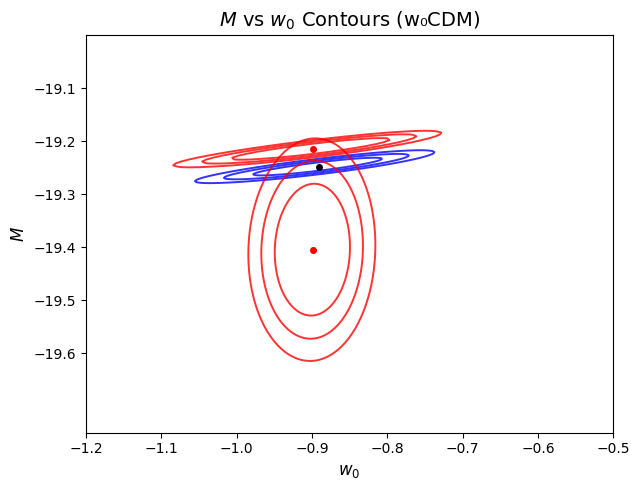

In [12]:
# --- Load raw chi2 data from .npz files ---
data_M_w0 = np.load("contour_data/contour_data_M_w0_w0CDM.npz")
data_Mlow_w0 = np.load("contour_data/contour_data_Mlow_w0_w0CDM_transition.npz")
data_Mhigh_w0 = np.load("contour_data/contour_data_Mhigh_w0_w0CDM_transition.npz")

# --- Grids ---
w0_range = data_M_w0["w0"]
M_range = data_M_w0["M"]

w0_range_low = data_Mlow_w0["w0"]
Mlow_range = data_Mlow_w0["Mlow"]

w0_range_high = data_Mhigh_w0["w0"]
Mhigh_range = data_Mhigh_w0["Mhigh"]

# --- Chi2 grids ---
chi2_Mw0 = data_M_w0["chi2"]
chi2_Mlow_w0 = data_Mlow_w0["chi2"]
chi2_Mhigh_w0 = data_Mhigh_w0["chi2"]

# --- Delta chi2 ---
dchi2_Mw0 = chi2_Mw0 - np.min(chi2_Mw0)
dchi2_Mlow_w0 = chi2_Mlow_w0 - np.min(chi2_Mlow_w0)
dchi2_Mhigh_w0 = chi2_Mhigh_w0 - np.min(chi2_Mhigh_w0)

# --- Best-fit points ---
w0_best = data_M_w0["w0_best"]
M_best = data_M_w0["M_best"]

w0_best_tr = data_Mlow_w0["w0_best"]
M_low_best = data_Mlow_w0["Mlow_best"]
M_high_best = data_Mhigh_w0["Mhigh_best"]

# --- Plot ---
plt.figure(figsize=(6.5, 5))

# No-transition (blue)
plt.contour(w0_range, M_range, dchi2_Mw0, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
plt.plot(w0_best, M_best, 'ko', markersize=4)

# Transition M< (red)
plt.contour(w0_range_low, Mlow_range, dchi2_Mlow_w0, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
plt.plot(w0_best_tr, M_low_best, 'ro', markersize=4)

# Transition M> (red)
plt.contour(w0_range_high, Mhigh_range, dchi2_Mhigh_w0, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
plt.plot(w0_best_tr, M_high_best, 'ro', markersize=4)

# Axis styling
plt.xlabel(r"$w_0$", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.xlim(w0_range.min(), w0_range.max())
plt.ylim(-19.75, -19.00)
plt.xticks(np.linspace(-1.2, -0.5, 8))
plt.yticks(np.linspace(-19.6, -19.1, 6))
plt.grid(False)

plt.title(r"$M$ vs $w_0$ Contours (w₀CDM)", fontsize=14)
plt.tight_layout()
plt.savefig("Figure1_w0_w0CDM_combined.pdf", dpi=300)
plt.show()


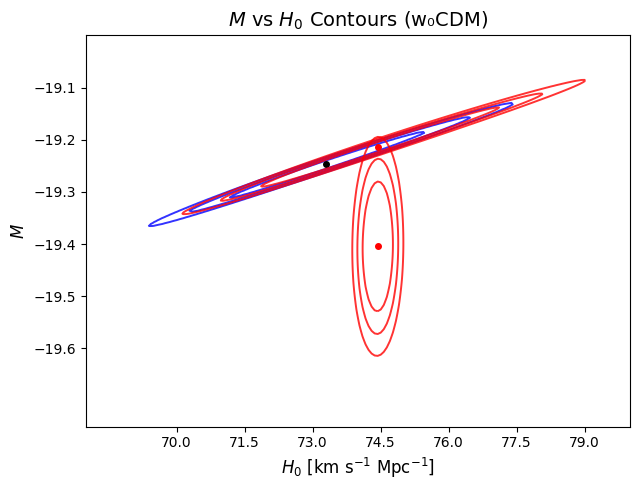

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import gamma

# --- ∆χ² utility ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

# --- Confidence levels ---
levels = [delta_chi2(n, 4) for n in [1, 2, 3]]             # No-transition (4 params)
levels_transition = [delta_chi2(n, 6) for n in [1, 2, 3]]  # Transition (6 params)

# --- Load chi2 data ---
data_M_H0 = np.load("contour_data/contour_data_M_H0_w0CDM.npz")
data_Mlow_H0 = np.load("contour_data/contour_data_Mlow_H0_w0CDM_transition.npz")
data_Mhigh_H0 = np.load("contour_data/contour_data_Mhigh_H0_w0CDM_transition.npz")

# --- Grids ---
H0_range = data_M_H0["H0"]
M_range = data_M_H0["M"]

H0_range_low = data_Mlow_H0["H0"]
Mlow_range = data_Mlow_H0["Mlow"]

H0_range_high = data_Mhigh_H0["H0"]
Mhigh_range = data_Mhigh_H0["Mhigh"]

# --- Chi2 values ---
dchi2_MH0 = data_M_H0["chi2"] - np.min(data_M_H0["chi2"])
dchi2_Mlow_H0 = data_Mlow_H0["chi2"] - np.min(data_Mlow_H0["chi2"])
dchi2_Mhigh_H0 = data_Mhigh_H0["chi2"] - np.min(data_Mhigh_H0["chi2"])

# --- Best fits ---
H0_best = data_M_H0["H0_best"]
M_best = data_M_H0["M_best"]

H0_best_tr = data_Mlow_H0["H0_best"]
M_low_best = data_Mlow_H0["Mlow_best"]
M_high_best = data_Mhigh_H0["Mhigh_best"]

# --- Plot ---
plt.figure(figsize=(6.5, 5))

# No-transition contour (blue)
plt.contour(H0_range, M_range, dchi2_MH0, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
plt.plot(H0_best, M_best, 'ko', markersize=4)

# Transition contours (red)
plt.contour(H0_range_low, Mlow_range, dchi2_Mlow_H0, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
plt.plot(H0_best_tr, M_low_best, 'ro', markersize=4)

plt.contour(H0_range_high, Mhigh_range, dchi2_Mhigh_H0, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
plt.plot(H0_best_tr, M_high_best, 'ro', markersize=4)

# Axis styling
plt.xlabel(r"$H_0$ [km s$^{-1}$ Mpc$^{-1}$]", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.xlim(H0_range.min(), H0_range.max())
plt.ylim(-19.75, -19.00)
plt.xticks(np.arange(70, 80.5, 1.5))
plt.yticks(np.linspace(-19.6, -19.1, 6))
plt.grid(False)

plt.title(r"$M$ vs $H_0$ Contours (w₀CDM)", fontsize=14)
plt.tight_layout()
plt.savefig("Figure_H0_w0CDM_combined.pdf", dpi=300)
plt.show()


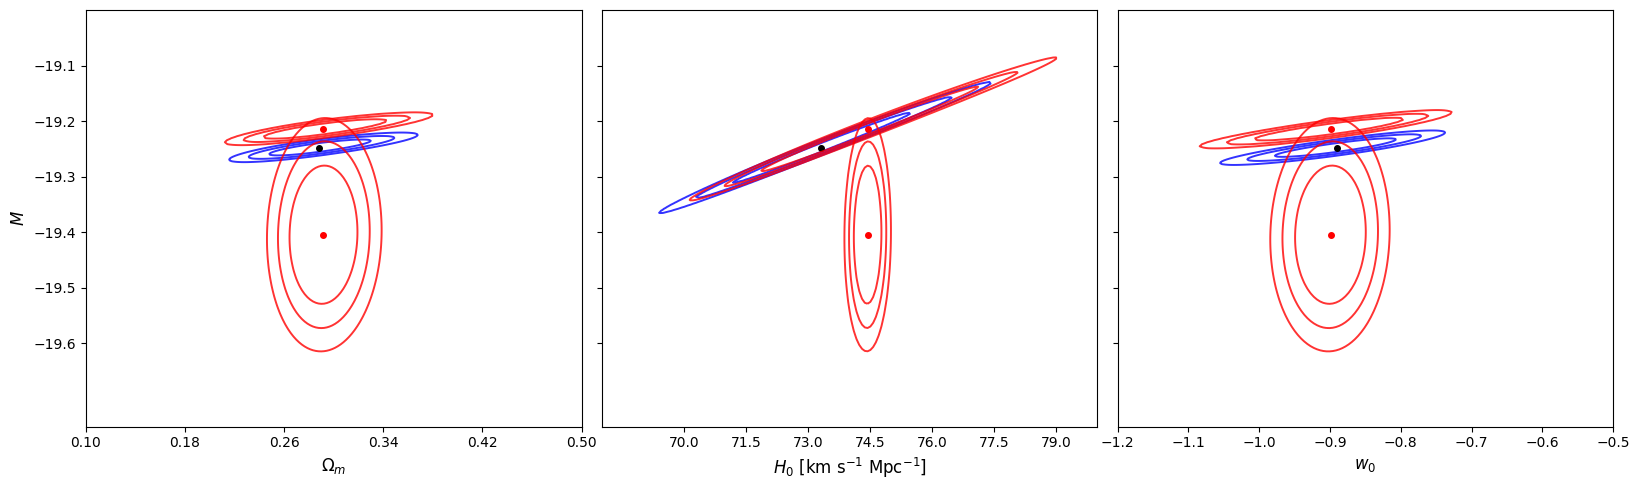

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import gamma

# --- ∆χ² level calculator ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 4) for n in [1, 2, 3]]
levels_transition = [delta_chi2(n, 6) for n in [1, 2, 3]]

# --- Load data for each panel ---
def load_data(prefix):
    d_std = np.load(f"contour_data/contour_data_M_{prefix}_w0CDM.npz")
    d_low = np.load(f"contour_data/contour_data_Mlow_{prefix}_w0CDM_transition.npz")
    d_high = np.load(f"contour_data/contour_data_Mhigh_{prefix}_w0CDM_transition.npz")
    return d_std, d_low, d_high

data_Om = load_data("Om")
data_H0 = load_data("H0")
data_w0 = load_data("w0")

# --- Plotting setup ---
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5), sharey=True)

# --- Panel configs ---
panels = [
    ("$\\Omega_m$", "Om", data_Om, np.linspace(0.10, 0.50, 6)),
    ("$H_0$ [km s$^{-1}$ Mpc$^{-1}$]", "H0", data_H0, np.arange(70, 80.5, 1.5)),
    ("$w_0$", "w0", data_w0, np.linspace(-1.2, -0.5, 8))
]

for ax, (xlabel, key, (d_std, d_low, d_high), xticks) in zip(axes, panels):
    # Grids
    x_std, y_std = d_std[key], d_std["M"]
    x_low, y_low = d_low[key], d_low["Mlow"]
    x_high, y_high = d_high[key], d_high["Mhigh"]

    # Delta chi2
    dchi2_std = d_std["chi2"] - np.min(d_std["chi2"])
    dchi2_low = d_low["chi2"] - np.min(d_low["chi2"])
    dchi2_high = d_high["chi2"] - np.min(d_high["chi2"])

    # Best-fit points
    x_best_std, y_best_std = d_std[f"{key}_best"], d_std["M_best"]
    x_best_tr, y_low_best = d_low[f"{key}_best"], d_low["Mlow_best"]
    _, y_high_best = d_high[f"{key}_best"], d_high["Mhigh_best"]

    # Plot contours
    ax.contour(x_std, y_std, dchi2_std, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
    ax.plot(x_best_std, y_best_std, 'ko', markersize=4)

    ax.contour(x_low, y_low, dchi2_low, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
    ax.plot(x_best_tr, y_low_best, 'ro', markersize=4)

    ax.contour(x_high, y_high, dchi2_high, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
    ax.plot(x_best_tr, y_high_best, 'ro', markersize=4)

    # Axis labels and ticks
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_xlim(x_std.min(), x_std.max())
    ax.set_xticks(xticks)
    ax.grid(False)

# Shared y-axis (M)
axes[0].set_ylabel(r"$M$", fontsize=12)
axes[0].set_ylim(-19.75, -19.00)
axes[0].set_yticks(np.linspace(-19.6, -19.1, 6))

# Titles


plt.tight_layout(w_pad=0.0)
plt.savefig("Combined_M_contours_w0CDM.png", dpi=300)
plt.show()


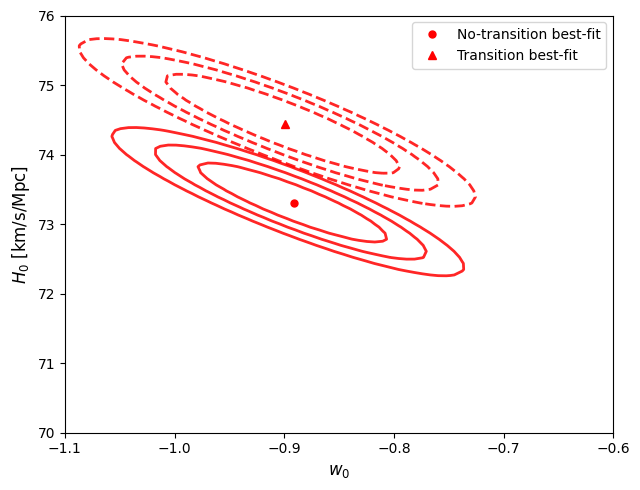

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import gamma

# --- ∆χ² utility ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

# --- Confidence levels ---
levels = [delta_chi2(n, 4) for n in [1, 2, 3]]             # No-transition
levels_transition = [delta_chi2(n, 6) for n in [1, 2, 3]]  # Transition

# --- Load precomputed grids ---
no_tr = np.load("contour_data/contour_data_H0_w0_w0CDM.npz")
tr = np.load("contour_data/contour_data_H0_w0_w0CDM_transition.npz")

H0_range = no_tr["H0"]
w0_range = no_tr["w0"]
dchi2_no_tr = no_tr["chi2"] - np.min(no_tr["chi2"])
H0_best = no_tr["H0_best"]
w0_best = no_tr["w0_best"]

H0_range_tr = tr["H0"]
w0_range_tr = tr["w0"]
dchi2_tr = tr["chi2"] - np.min(tr["chi2"])
H0_best_tr = tr["H0_best"]
w0_best_tr = tr["w0_best"]

# --- Plot ---
plt.figure(figsize=(6.5, 5))

# No-transition contours (solid red)
plt.contour(w0_range, H0_range, dchi2_no_tr, levels=levels, colors='red', linewidths=2.0, linestyles='solid', alpha=0.85)
plt.plot(w0_best, H0_best, 'ro', label="No-transition best-fit", markersize=5)

# Transition contours (dashed red)
plt.contour(w0_range_tr, H0_range_tr, dchi2_tr, levels=levels_transition, colors='red', linewidths=2.0, linestyles='dashed', alpha=0.85)
plt.plot(w0_best_tr, H0_best_tr, 'r^', label="Transition best-fit", markersize=6)

# --- Axis styling ---
plt.xlabel(r"$w_0$", fontsize=12)
plt.ylabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.xticks(np.linspace(-1.1, -0.6, 6))
plt.yticks(np.arange(70, 76.5, 1))
plt.xlim(w0_range.min(), w0_range.max())
plt.ylim(H0_range.min(), H0_range.max())


plt.grid(False)
plt.legend()
plt.tight_layout()
plt.savefig("Combined_H0_w0_w0CDM_overlay.png", dpi=300)
plt.show()


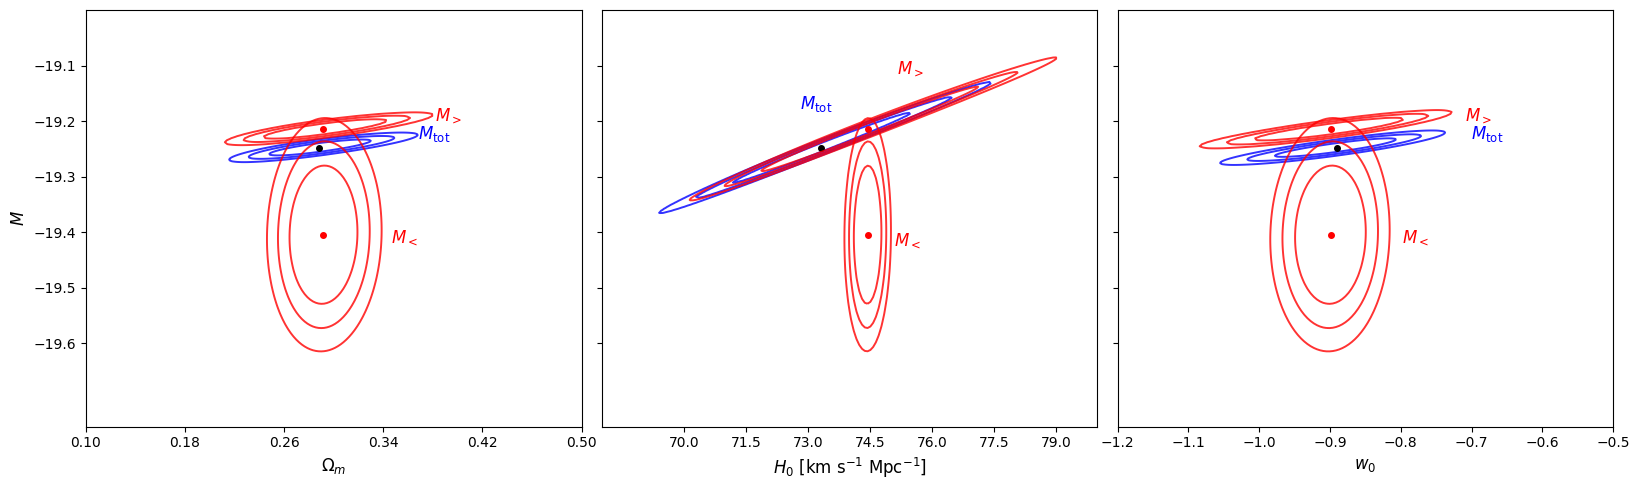

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import gamma

# --- ∆χ² level calculator ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 4) for n in [1, 2, 3]]
levels_transition = [delta_chi2(n, 6) for n in [1, 2, 3]]

# --- Load data for each panel ---
def load_data(prefix):
    d_std = np.load(f"contour_data/contour_data_M_{prefix}_w0CDM.npz")
    d_low = np.load(f"contour_data/contour_data_Mlow_{prefix}_w0CDM_transition.npz")
    d_high = np.load(f"contour_data/contour_data_Mhigh_{prefix}_w0CDM_transition.npz")
    return d_std, d_low, d_high

data_Om = load_data("Om")
data_H0 = load_data("H0")
data_w0 = load_data("w0")

# --- Plotting setup ---
fig, axes = plt.subplots(1, 3, figsize=(16.5, 5), sharey=True)

# --- Panel configs ---
panels = [
    ("$\\Omega_m$", "Om", data_Om, np.linspace(0.10, 0.50, 6)),
    ("$H_0$ [km s$^{-1}$ Mpc$^{-1}$]", "H0", data_H0, np.arange(70, 80.5, 1.5)),
    ("$w_0$", "w0", data_w0, np.linspace(-1.2, -0.5, 8))
]
# --- Label offsets per panel ---
label_offsets = {
    "Om": {
        "M<": (0.055, -0.015),
        "M>": (0.09, 0.015),
        "Mtot": (0.08, 0.015)
    },
    "H0": {
        "M<": (0.65, -0.02),
        "M>": (0.7, 0.1),
        "Mtot": (-0.5, 0.07)
    },
    "w0": {
        "M<": (0.1, -0.015),
        "M>": (0.19, 0.015),
        "Mtot": (0.19, 0.015)
    }
}
for ax, (xlabel, key, (d_std, d_low, d_high), xticks) in zip(axes, panels):
    # Grids
    x_std, y_std = d_std[key], d_std["M"]
    x_low, y_low = d_low[key], d_low["Mlow"]
    x_high, y_high = d_high[key], d_high["Mhigh"]

    # Delta chi2
    dchi2_std = d_std["chi2"] - np.min(d_std["chi2"])
    dchi2_low = d_low["chi2"] - np.min(d_low["chi2"])
    dchi2_high = d_high["chi2"] - np.min(d_high["chi2"])

    # Best-fit points
    x_best_std, y_best_std = d_std[f"{key}_best"], d_std["M_best"]
    x_best_tr, y_low_best = d_low[f"{key}_best"], d_low["Mlow_best"]
    _, y_high_best = d_high[f"{key}_best"], d_high["Mhigh_best"]

    # Plot contours
    ax.contour(x_std, y_std, dchi2_std, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
    ax.plot(x_best_std, y_best_std, 'ko', markersize=4)

    ax.contour(x_low, y_low, dchi2_low, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
    ax.plot(x_best_tr, y_low_best, 'ro', markersize=4)

    ax.contour(x_high, y_high, dchi2_high, levels=levels_transition, colors='red', linewidths=1.4, alpha=0.8)
    ax.plot(x_best_tr, y_high_best, 'ro', markersize=4)

   # Get manual offsets for this panel
    dx_low, dy_low = label_offsets[key]["M<"]
    dx_high, dy_high = label_offsets[key]["M>"]
    dx_tot, dy_tot = label_offsets[key]["Mtot"]

    # Add best-fit parameter labels
    ax.text(x_best_tr + dx_low, y_low_best + dy_low, r"$M_{<}$", color='red', fontsize=12)
    ax.text(x_best_tr + dx_high, y_high_best + dy_high, r"$M_{>}$", color='red', fontsize=12)
    ax.text(x_best_std + dx_tot, y_best_std + dy_tot, r"$M_{\mathrm{tot}}$", color='blue', fontsize=12)
    # Axis labels and ticks
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_xlim(x_std.min(), x_std.max())
    ax.set_xticks(xticks)
    ax.grid(False)


# Shared y-axis (M)
axes[0].set_ylabel(r"$M$", fontsize=12)
axes[0].set_ylim(-19.75, -19.00)
axes[0].set_yticks(np.linspace(-19.6, -19.1, 6))

# Titles


plt.tight_layout(w_pad=0.0)
plt.savefig("Combined_M_contours_w0CDM.png", dpi=300)
plt.show()
